In [1]:
# control seed for reproducibility

import os
import random
import numpy as np
import torch


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed = 0
set_all_seeds(seed)


Packages used:

- py-irt
- pyro-ppl (required by py-irt)
- torch (required by pyro-ppl)
- catboost
- sklearn, pandas, numpy, seaborn

In [2]:
# imports

import pandas as pd
import numpy as np
import json
import seaborn as sns
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

sns.set(rc={"figure.figsize": (11.7, 8.27)})


# Brief overview

Given the dataset of historical data of student performances on test, I was asked to predict probability of correct answer for the next question

# Table of contents

This notebook is structured as following:

- Brief overview
- Exploratory data analysis
  - Data documentation
  - Training & test data overview
  - aggregated summary of training data
  - how the train/test was split?
- data splitting
- prediction baseline
- prediction using model
- decomposing student ability and question difficulty
- item response theory (IRT)
   - preprocessing for IRT
   - EDA of IRT on full dataset
   - Performance of IRT on split dataset
- conclusion of the best model of the experiment
- final submission

You can use the Outline / Table of Content from jupyter on the left sidebar for easier navigation 

# Exploratory data analysis:

## Data Documentation

From the documentation, the relationships between columns are explained this way:

- 1 topic has many subtopic (one to many)
- 1 has many learning node (one to many)
- 1 subtopic has many questions (one to many)
- learning node to questions are many to many

## Training & test data overview

In [3]:
df = pd.read_csv("train.csv")
df.shape


(286886, 18)

In [98]:
train.is_correct.sum(), train.is_correct.count(), train.is_correct.sum() / train.is_correct.count()

(110854.0, 172131, 0.644009504389099)

I will summary both train & test dataframe, checks including:

- has nan?
- number of unique values
- list of unique values

In [4]:
def df_summarier(df):
    a = df.isna().any(axis=0)
    b = df.nunique()
    c = pd.Series({col: df[col].unique() for col in df})
    return pd.concat([a, b, c], axis=1).rename(
        columns={0: "has nan?", 1: "num of unique values", 2: "list of unique values"}
    )


# train


df_summarier(df)


,has nan?,num of unique values,list of unique values
user_id,False,7000,"[2348875, 2766044, 3604867, 4061807, 5713467, ..."
session_id,False,47222,"[5473538500, 3206055652, 9605991415, 725546045..."
session_no,False,1311,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ..."
topic,False,1639,"[1064573894, 4794286044, 1737274108, 484457666..."
sub_topic,False,2265,"[6164056362, 6471306273, 2158335016, 688757428..."
learning_node,False,12093,"[1683819444, 3791168789, 7856645946, 281267882..."
question_id,False,30653,"[2226271822, 5592568637, 1243898418, 473279859..."
question_type,False,3,"[Single choice, Multi choice, single choice]"
session_question_no,False,44,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
learning_node_question_no,False,32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [5]:
# test

testdf = pd.read_csv("test.csv")
df_summarier(testdf)


,has nan?,num of unique values,list of unique values
user_id,False,7000,"[2348875, 2766044, 3604867, 4061807, 5713467, ..."
session_id,False,7000,"[3206055652, 2972889287, 8630265714, 731591200..."
session_no,False,116,"[2.0, 11.0, 4.0, 10.0, 3.0, 9.0, 1.0, 16.0, 6...."
topic,False,1132,"[1064573894, 1737274108, 2624511878, 147927464..."
sub_topic,False,1229,"[6164056362, 6197171301, 5665086549, 277442736..."
learning_node,False,3591,"[1683819444, 8772005155, 1064446677, 746987330..."
question_id,False,4829,"[2226271822, 8350981375, 7911407965, 236807865..."
question_type,False,2,"[Single choice, Multi choice]"
session_question_no,False,27,"[2, 6, 8, 7, 9, 1, 4, 12, 10, 14, 5, 3, 15, 18..."
learning_node_question_no,False,9,"[2, 1, 3, 7, 6, 4, 33, 13, 12]"


#### Fixing data

Given the existence of wrong case (`Single choice` vs `single choice`) and unknown (NaN) difficulty, I will rename the cells and impute the `nan`s with `others` before I proceed

In [6]:
# fixing data

df.replace({"single choice": "Single choice"}, inplace=True)
df.fillna("other", inplace=True)
testdf.fillna("other", inplace=True)


In [7]:
# train

df_summarier(df)


,has nan?,num of unique values,list of unique values
user_id,False,7000,"[2348875, 2766044, 3604867, 4061807, 5713467, ..."
session_id,False,47222,"[5473538500, 3206055652, 9605991415, 725546045..."
session_no,False,1311,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ..."
topic,False,1639,"[1064573894, 4794286044, 1737274108, 484457666..."
sub_topic,False,2265,"[6164056362, 6471306273, 2158335016, 688757428..."
learning_node,False,12093,"[1683819444, 3791168789, 7856645946, 281267882..."
question_id,False,30653,"[2226271822, 5592568637, 1243898418, 473279859..."
question_type,False,2,"[Single choice, Multi choice]"
session_question_no,False,44,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
learning_node_question_no,False,32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [8]:
# test

df_summarier(testdf)


,has nan?,num of unique values,list of unique values
user_id,False,7000,"[2348875, 2766044, 3604867, 4061807, 5713467, ..."
session_id,False,7000,"[3206055652, 2972889287, 8630265714, 731591200..."
session_no,False,116,"[2.0, 11.0, 4.0, 10.0, 3.0, 9.0, 1.0, 16.0, 6...."
topic,False,1132,"[1064573894, 1737274108, 2624511878, 147927464..."
sub_topic,False,1229,"[6164056362, 6197171301, 5665086549, 277442736..."
learning_node,False,3591,"[1683819444, 8772005155, 1064446677, 746987330..."
question_id,False,4829,"[2226271822, 8350981375, 7911407965, 236807865..."
question_type,False,2,"[Single choice, Multi choice]"
session_question_no,False,27,"[2, 6, 8, 7, 9, 1, 4, 12, 10, 14, 5, 3, 15, 18..."
learning_node_question_no,False,9,"[2, 1, 3, 7, 6, 4, 33, 13, 12]"


There are many categorical columns.

- High cardinality includes: session_id, topic, sub_topic, learning_node, question_id
- Low cardinality includes: question_type, question_difficulty, question_number_of_choice

In [9]:
# column difference between train and test

different_columns = set(df.columns) - set(testdf.columns)
different_columns


{'is_correct',
 'ms_first_response',
 'question_number_of_correct_selected',
 'question_number_of_wrong_selected'}

since `is_correct` is the label, it wont be available on the test set. the same goes with the rest three columns

Here I will display the intersection between train df and test df

In [10]:
def inter(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    intersection = len(set1 & set2)
    return intersection


def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return float(intersection) / union


def per_subset(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    intersection = len(set1 & set2)

    return intersection / len(set2)


# summarize the intersection between train and test dataset


intersectiondf = pd.DataFrame(
    [
        {
            "colname": col,
            "train_nunique": len(set(df[col])),
            "test_nunique": len(set(testdf[col])),
            "intersecting_elements": inter(df[col], testdf[col]),
            "%intersection_test_and_train(jaccard)": jaccard_similarity(
                df[col], testdf[col]
            ),
            "%subset_test_in_train": per_subset(df[col], testdf[col]),
        }
        for col in testdf.columns
        if col not in ["row_id"] and not col.endswith("no")
    ]
)
intersectiondf


,colname,train_nunique,test_nunique,intersecting_elements,%intersection_test_and_train(jaccard),%subset_test_in_train
0,user_id,7000,7000,7000,1.000000,1.000000
1,session_id,47222,7000,6377,0.133285,0.911000
2,topic,1639,1132,1127,0.685523,0.995583
3,sub_topic,2265,1229,1225,0.539885,0.996745
4,learning_node,12093,3591,3517,0.289061,0.979393
5,question_id,30653,4829,4470,0.144138,0.925657
6,question_type,2,2,2,1.000000,1.000000
7,question_difficulty,5,5,5,1.000000,1.000000
8,question_number_of_choice,5,4,4,0.800000,1.000000
9,question_number_of_correct_choice,1,1,1,1.000000,1.000000


here we are interested in the intersection between the two datasets:

- user_id is 100% same between training and testing. Modelling the users could be very important, especially for personalization
- test dataset has lot of similarity with the training dataset, given 90% of test elements contained in the training dataset
- `question_number_of_correct_choice` has only 1 value and would be discarded

## Aggregated summary on training data

In [11]:
df.groupby("question_number_of_choice").agg(
    Mean=("is_correct", np.mean),
    correct=("is_correct", np.sum),
    total=("is_correct", len),
)


,Mean,correct,total
question_number_of_choice,,,
2,0.814815,66.0,81
3,0.799153,55307.0,69207
4,0.625896,97912.0,156435
5,0.515705,31540.0,61159
6,1.000000,4.0,4


users perform better on question with the lesser number of choice, except for 6 which is only 4 rows in the training dataset

In [12]:
df.fillna("other").groupby("question_type").agg(
    Mean=("is_correct", np.mean),
    correct=("is_correct", np.sum),
    total=("is_correct", len),
)


,Mean,correct,total
question_type,,,
Multi choice,0.479592,141.0,294
Single choice,0.644428,184688.0,286592


users perform better on single choice questions than on multi choice. but the existence of multi choice questions are rare

In [69]:
df.fillna("other").groupby("question_difficulty").agg(
    mean=("is_correct", np.mean),
    correct=("is_correct", np.sum),
    total=("is_correct", len),
)


,mean,correct,total
question_difficulty,,,
easy,0.682595,3314.0,4855
hard,0.548100,678.0,1237
hots,0.554852,263.0,474
medium,0.533157,60677.0,113807
other,0.720046,119897.0,166513


- interestingly users perform better in this order of difficulty: `other > easy > hots > hard > medium`, rather than `hard > medium > easy`
- users had more success with`other` than `easy`, while `medium` is the hardest of them all compared to `hard` and `hots`
- `medium` and `other` has many samples. `easy, hard, and hots` has less than 5000 rows

## Was the testing data split chronologically?

Is testing data happen strictly after training data?

In [14]:
testdf[testdf.session_no == 1].head()


,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_difficulty,question_number_of_choice,question_number_of_correct_choice,row_id
6,8411515,2944192518,1.0,9497051691,2169408725,4507088908,7137101883,Single choice,4,1,medium,4,1,6
8,10434119,1948335987,1.0,836785970,3125507700,1399112274,9707454783,Single choice,6,3,medium,4,1,8
9,11855819,4479660934,1.0,8346451289,3142361831,5939885926,5030807848,Single choice,6,3,medium,4,1,9
11,14706019,7389186610,1.0,6089180138,5665086549,4134891942,7787387786,Single choice,4,2,other,4,1,11
12,17368199,4642112795,1.0,3214173988,272680675,921703945,4040758340,Single choice,10,2,medium,3,1,12


In [15]:
sett = set(testdf[testdf.session_no == 1].user_id)


In [16]:
df[df.user_id.isin(sett)]


,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_difficulty,question_number_of_choice,question_number_of_correct_choice,question_number_of_correct_selected,question_number_of_wrong_selected,ms_first_response,is_correct,row_id
247,8411515,2944192518,1.0,9497051691,1469843971,5136679131,3227503528,Single choice,1,1,medium,4,1,1,0,25.0,1.0,247
248,8411515,2944192518,1.0,9497051691,1469843971,5136679131,9483284731,Single choice,2,2,medium,4,1,0,1,34.0,0.0,248
249,8411515,2944192518,1.0,9497051691,1469843971,5136679131,2539781090,Single choice,3,3,medium,4,1,0,1,20.0,0.0,249
415,10434119,1948335987,1.0,836785970,3125507700,8654954538,9857897229,Single choice,1,1,medium,4,1,1,0,59.0,1.0,415
416,10434119,1948335987,1.0,836785970,3125507700,8654954538,787959041,Multi choice,2,2,medium,4,1,0,1,56.0,0.0,416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286556,9986414625,4689780633,1.0,9922825353,1678010373,1545161003,2648738180,Single choice,1,1,medium,4,1,1,0,141.0,1.0,286556
286557,9986414625,4689780633,1.0,9922825353,3624053133,3160370456,2176526969,Single choice,2,1,medium,4,1,1,0,112.0,1.0,286557
286558,9986414625,4689780633,1.0,9922825353,3624053133,4655369784,9074043238,Single choice,3,1,medium,4,1,1,0,27.0,1.0,286558
286559,9986414625,4689780633,1.0,9922825353,7631249768,5801494200,956896945,Single choice,4,1,medium,5,1,0,1,225.0,0.0,286559


Looks like the data are not split in a time-series way, so I will just split the data randomly using train_test_split

# Splitting

I split the data into 60:20:20 train:validation:testing

In [17]:
train, test_and_valid = train_test_split(df, test_size=0.4, random_state=seed)
test, valid = train_test_split(test_and_valid, test_size=0.5, random_state=seed)

# Prediction baseline

Di sini kita ingin memprediksi probabilitas suatu soal $s$ berhasil dijawab oleh User $u$.  
Secara sederhana, faktor-faktor yang berpengaruh dalam terjawabnya soal oleh user adalah kemampuan user dan kesulitan soal.

sebagai baseline, saya akan melakukan prediksi tanpa menggunakan model machine learning, tetapi hanya dengan menggunakan dictionary aggregat sederhana dari topik, subtopik, dan difficulty.  

In [70]:
train.columns


Index(['user_id', 'session_id', 'session_no', 'topic', 'sub_topic',
       'learning_node', 'question_id', 'question_type', 'session_question_no',
       'learning_node_question_no', 'question_difficulty',
       'question_number_of_choice', 'question_number_of_correct_choice',
       'question_number_of_correct_selected',
       'question_number_of_wrong_selected', 'ms_first_response', 'is_correct',
       'row_id'],
      dtype='object')

In [71]:
dfbaseline = (
    train.groupby(["topic", "sub_topic", "learning_node"])
    .agg({"is_correct": "mean", "question_id": "nunique", "user_id": "nunique"})
    .sort_values(by=["user_id", "is_correct"], ascending=False)
    .reset_index()
)


## Baseline - training score

In [104]:
train2 = train.merge(
    dfbaseline[["topic", "sub_topic", "learning_node", "is_correct"]].rename(
        columns={"is_correct": "pred_correct"}
    ),
    on=["topic", "sub_topic", "learning_node"],
    how="left",
).copy()
roc_auc_score(train2["is_correct"], train2["pred_correct"])

0.7942529199751017

## Baseline - validation score

In [119]:
val2 = valid.merge(
    dfbaseline[["topic", "sub_topic", "learning_node", "is_correct"]].rename(
        columns={"is_correct": "pred_correct"}
    ),
    on=["topic", "sub_topic", "learning_node"],
    how="left",
).copy()
val2.pred_correct = val2.pred_correct.fillna(val2.pred_correct.mean())
roc_auc_score(test2["is_correct"], test2["pred_correct"])


0.6981546605164384

## Baseline - test score

In [187]:
test2 = test.merge(
    dfbaseline[["topic", "sub_topic", "learning_node", "is_correct"]].rename(
        columns={"is_correct": "pred_correct"}
    ),
    on=["topic", "sub_topic", "learning_node"],
    how="left",
).copy()
test2.pred_correct = test2.pred_correct.fillna(test2.pred_correct.mean())

ypbaseline=test2.pred_correct
roc_auc_score(test2["is_correct"], test2["pred_correct"])


0.6917575213595224

Dengan menggunakan baseline sederhana, didapatkan auc sebesar 0.69. Sehingga, model yang akan dibuat harus bisa lebih tinggi dari baseline sederhana ini

# Prediction using CatBoost

Gradient Boosting adalah teknik yang memiliki performa baik dan sering dipakai di kaggle. Contoh library terkenal adalah XGBoost, namun pada assignment ini saya menggunakan Catboost, karena:

- memiliki parameter default yang cukup baik, dibanding xgboost yang perlu banyak tuning
- learning rate otomatis sesuai dataset
- handle categorical features secara otomatis, tidak perlu melakukan onehot untuk kolom low-cardinality, ataupun trik encoding lainnya untuk kolom high-cardinality

sehingga:

- mempercepat proses modelling untuk waktu yang terbatas ini; dan
- kode lebih mudah di-maintain

In [24]:
cat_features = [
    "question_difficulty",
    "question_type",
    "sub_topic",
    "question_number_of_choice",
    "learning_node",
    "topic",
    "question_id",
]
drop_cols = [
    "user_id",
    "session_id",
    "session_no",
    "row_id",
    "session_question_no",
    "learning_node_question_no",
    "question_number_of_correct_choice",
]
list_inter = list(set(df.columns) & set(testdf.columns))



In [25]:
X_train = train[list_inter].drop(drop_cols, axis=1)
y_train = train.is_correct

X_valid = valid[list_inter].drop(drop_cols, axis=1)
y_valid = valid.is_correct

X_test = test[list_inter].drop(drop_cols, axis=1)
y_test = test.is_correct


Beberapa parameter CatBoost yang akan kita override adalah jumlah max iterasi, loss function, evaluation metric, random seed, dan early stopping:


In [26]:
CATBOOST_PARAM = {
    "iterations": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": seed,
}
CATBOOST_FIT_PARAM = {
    "use_best_model": True,
    "verbose": False,
    "plot": True,
    "early_stopping_rounds": 50,
}


Berikut kita ujicobakan model dengan dataset yang kebanyakan menggunakan data categorical:

In [27]:
clf = CatBoostClassifier(**CATBOOST_PARAM)
clf.fit(
    X_train, y_train, cat_features, eval_set=(X_valid, y_valid), **CATBOOST_FIT_PARAM
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [191]:
yp = clf.predict_proba(X_train)
tr = roc_auc_score(y_train, yp[:, 1])

yp = clf.predict_proba(X_valid)
va = roc_auc_score(y_valid, yp[:, 1])

yp2 = clf.predict_proba(X_test)
te = roc_auc_score(y_test, yp2[:, 1])

ypredcbonly=yp2

tr, va, te


(0.8092758276298564, 0.737109453637798, 0.736325570775935)

Oleh modelling sederhana dengan catboost, didapatkan validation score 0.73, dan test score 0.73.

In [145]:
pd.DataFrame([clf.feature_names_, clf.get_feature_importance()]).T 

,0,1
0,question_number_of_choice,6.623377
1,question_id,27.207969
2,topic,28.9309
3,question_difficulty,6.052052
4,question_type,0.027813
5,learning_node,23.30947
6,sub_topic,7.848419


Dari hasil feature importances:

- `question_type` memiliki importances yang sangat rendah dibanding fitur lain, sehingga bisa di-remove

# Decomposing student ability and question difficulty

Pada pembahasan sebelumnya, kita telah membahas bahwa faktor utama probabilitas soal terjawab adalah sebagai berikut:

- kesulitan soal
- kemampuan user
- randomness dari user (keberuntungan, keteledoran)

Kita sudah mencoba membangun baseline walau hanya dengan agregat. Pada kesempatan kali ini, kita mencoba untuk dekomposisi kemampuan pelajar, kessulitan soal, dan faktor-faktor lain hingga menjadi fitur/kolom tersendiri.

Yang pertama terlintas di pikiran saya adalah Multilevel Modelling seperti pada dataset Radon https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html

Kira-kira seperti ini: Prob = intercept + difficulty_soal[id_soal] + ability_user[id_user] + luck_user[id_user] + carelessness_user[id_user] + ... 

Namun  dari hasil studi literatur, didapatkan salah satu model untuk memodelkan ini sudah ada, yaitu Item Response Theory.  
Selain itu, ditemukan fitur lain seperti `question_discrimination` dan luck/carelessness yaitu `lambda`, dan bersifat sebagai pengali, bukan additive seperti contoh di atas.

Oleh karena itu, saya melakukan eksperimen dengan IRT


# Item Response Theory

Berikut referensi yang saya sarankan untuk memahami IRT dengan mudah:
- https://www.publichealth.columbia.edu/research/population-health-methods/item-response-theory
- https://arxiv.org/abs/2203.01282
- https://en.wikipedia.org/wiki/Item_response_theory#The_item_response_function

Ada beberapa variasi model IRT, secara singkat perbedaan terdapat pada latent variable-nya :

- 1PL: ability, difficulty
- 2PL: ability, difficulty, discrimination
- 4PL: ability, difficulty, discrimination, luck, carelessness

## Preprocessing for item response theory

library yang digunakan adalah py-irt. cara kerja ada di paper  https://arxiv.org/abs/2203.01282

In [29]:
# transform to irt input
def transform_to_irt_input(df_input: "pd.DataFrame", jsonl_name: str):
    dik1 = {}
    for row in df_input.itertuples():
        if row.user_id not in dik1:
            dik1[row.user_id] = {"responses": {}}

        dik1[row.user_id]["responses"][str(row.question_id)] = (
            1 if row.is_correct else 0
        )

    lisdik2 = [{"subject_id": k, "responses": v["responses"]} for k, v in dik1.items()]

    import json

    with open(jsonl_name, "w") as outfile:
        for entry in lisdik2:
            json.dump(entry, outfile)
            outfile.write("\n")


Berikut rumus prediksi dari Item Response Theory untuk n-PL (Parameter Logistic):

In [30]:
"""
abilities = kemampuan user
diffs = difficulty dari soal
disc = discrimination factor dari soal
lambdas= faktor randomness dari user (tebakan benar / keteledoran)
"""


def predict_1pl(abilities, diffs):
    return 1 / (1 + np.exp(-(abilities - diffs)))


def predict_2pl(abilities, diffs, discs):
    return 1 / (1 + np.exp(-discs * (abilities - diffs)))


def predict_4pl(abilities, diffs, discs, lambdas):
    return lambdas / (1 + np.exp(-discs * (abilities - diffs)))


## Item Response Theory on the full training dataset and EDA

Untuk kebutuhan EDA, dilakukan fitting model Item Response Theory.  
(Berikutnya juga akan dilakukan evaluasi terhadap splitted dataset. Untuk bagian ini, strictly untuk EDA.)

In [31]:
fulltrain = df.copy()
transform_to_irt_input(fulltrain, "fulltrain.jsonl")


### 1PL on full training data

In [32]:
!py-irt train 1pl final.jsonl fulltrain1pl


[19:38:35] config: model_type='1pl' epochs=2000 priors=None           cli.py:66
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                    
           dropout=0.5 hidden=100 vocab_size=None                              
           data_path: final.jsonl                                     cli.py:68
           output directory: fulltrain1pl                             cli.py:69
False
None
[19:38:37] Training Model...                                          cli.py:73
{'device': 'cpu', 'num_items': 30653, 'num_subjects': 7000}
[19:38:37] Parsed Model Args: {'device': 'cpu', 'num_items':    training.py:124
           30653, 'num_subjects': 7000, 'priors': 'vague',                     
           'dropout': 0.5, 'hidden': 100, 'vocab_size': None}                  
torch.Size([172995]) torch.Size([172995])
Training Pyro IRT Model for 2000 epochs
+------------------------------------------------+
| Epoch | Loss          | Best Loss     | New LR |
|-------+---------------+

In [33]:
# transform from irt input
import json

f = open("fulltrain1pl/best_parameters.json").read()
d = json.loads(f)
duid = {int(k): int(v) for k, v in d["subject_ids"].items()}
dability = dict(zip(map(int, d["subject_ids"].values()), d["ability"]))
ddiff = dict(zip(map(int, d["item_ids"].values()), d["diff"]))

fulltrain1pl = fulltrain.copy()

# transform to irt
fulltrain1pl["ability"] = fulltrain1pl.user_id.map(dability)
fulltrain1pl["diff"] = fulltrain1pl.question_id.map(ddiff)

fulltrain1pl.fillna("other").groupby("question_difficulty").agg(
    Mean_is_correct=("is_correct", np.mean),
    Mean_diff_IRT=("diff", np.mean),
    correct=("is_correct", np.sum),
    total=("is_correct", len),
).sort_values("Mean_diff_IRT")


,Mean_is_correct,Mean_diff_IRT,correct,total
question_difficulty,,,,
other,0.720046,-3.605294,119897.0,166513
easy,0.682595,-2.825878,3314.0,4855
hard,0.548100,-2.265519,678.0,1237
hots,0.554852,-0.190259,263.0,474
medium,0.533157,-0.083921,60677.0,113807


### 2PL on full training data

In [34]:
!py-irt train 2pl final.jsonl fulltrain2pl


[19:39:33] config: model_type='2pl' epochs=2000 priors=None           cli.py:66
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                    
           dropout=0.5 hidden=100 vocab_size=None                              
           data_path: final.jsonl                                     cli.py:68
           output directory: fulltrain2pl                             cli.py:69
False
None
[19:39:35] Training Model...                                          cli.py:73
{'device': 'cpu', 'num_items': 30653, 'num_subjects': 7000}
[19:39:35] Parsed Model Args: {'device': 'cpu', 'num_items':    training.py:124
           30653, 'num_subjects': 7000, 'priors': 'vague',                     
           'dropout': 0.5, 'hidden': 100, 'vocab_size': None}                  
torch.Size([172995]) torch.Size([172995])
Training Pyro IRT Model for 2000 epochs
+--------------------------------------------------+
| Epoch | Loss           | Best Loss      | New LR |
|-------+------------

In [35]:
# transform from irt input
import json

f = open("fulltrain2pl/best_parameters.json").read()
d = json.loads(f)
duid = {int(k): int(v) for k, v in d["subject_ids"].items()}
dability = dict(zip(map(int, d["subject_ids"].values()), d["ability"]))
ddiff = dict(zip(map(int, d["item_ids"].values()), d["diff"]))
ddisc = dict(zip(map(int, d["item_ids"].values()), d["disc"]))


fulltrain2pl = fulltrain.copy()

# transform to irt
fulltrain2pl["ability"] = fulltrain2pl.user_id.map(dability)
fulltrain2pl["diff"] = fulltrain2pl.question_id.map(ddiff)
fulltrain2pl["disc"] = fulltrain2pl.question_id.map(ddisc)


fulltrain2pl.fillna("other").groupby("question_difficulty").agg(
    correct=("is_correct", np.sum),
    total=("is_correct", len),
    Mean_is_correct=("is_correct", np.mean),
    Mean_diff_IRT=("diff", np.mean),
    Mean_disc_IRT=("disc", np.mean),
).sort_values("Mean_diff_IRT")


,correct,total,Mean_is_correct,Mean_diff_IRT,Mean_disc_IRT
question_difficulty,,,,,
easy,3314.0,4855,0.682595,-0.070469,0.177989
other,119897.0,166513,0.720046,-0.016404,0.137478
medium,60677.0,113807,0.533157,-0.001365,0.032827
hots,263.0,474,0.554852,-0.000090,0.053356
hard,678.0,1237,0.548100,0.010486,0.022351


Dapat dilihat bahwa IRT mampu dekomposisi ke individual ability user dan difficulty soal, terutama IRT-2PL yang mampu memodelkan kesulitan soal dengan `easy < medium < hard`

Model IRT ini sebenarnya bisa langsung digunakan, karena sebenarnya ia bisa mengeluarkan prediksi lewat rumus logistic-nya. 

Namun hal tersebut tidak saya lakukan karena jika ada missing, unknown person & unknown soal, hasilnya akan buruk. Sehingga fitur categorical seperti `topic, sub_topic` akan sangat membantu bila terjadi missing value. Oleh karena itu, saya masukkan lagi ke model, dalam kasus ini adalah CatBoost.


## Item Response Theory on splitted dataset

Eksperimen lanjutan adalah bertujuan untuk menjawab pertanyaan berikut:

- apakah IRT dapat menaikkan skor AUC pada split dataset
- model IRT yang mana yang paling meningkatkan skor AUC?
- jika terjadi missing value, strategi imputasi mana yang paling baik? impute dengan mean, median, atau cara lain?

DataFrame yang diguanakan adalah fitur kategorikal (difficulty, topic, sub_topic, learning_node, question_id) bersama fitur IRT, yaitu:

- 1PL: ability, difficulty
- 2PL: ability, discrimination factor
- 4PL: ability, discrimination factor, lambda (user randomness)


### IRT-1PL on split

In [36]:
!py-irt train 1pl trainsplit.jsonl train1pl


[19:40:58] config: model_type='1pl' epochs=2000 priors=None           cli.py:66
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                    
           dropout=0.5 hidden=100 vocab_size=None                              
           data_path: trainsplit.jsonl                                cli.py:68
           output directory: train1pl                                 cli.py:69
False
None
[19:40:59] Training Model...                                          cli.py:73
{'device': 'cpu', 'num_items': 26206, 'num_subjects': 6723}
[19:40:59] Parsed Model Args: {'device': 'cpu', 'num_items':    training.py:124
           26206, 'num_subjects': 6723, 'priors': 'vague',                     
           'dropout': 0.5, 'hidden': 100, 'vocab_size': None}                  
torch.Size([120884]) torch.Size([120884])
Training Pyro IRT Model for 2000 epochs
+------------------------------------------------+
| Epoch | Loss          | Best Loss     | New LR |
|-------+---------------+

In [37]:
# transform from irt input
import json

f = open("train1pl/best_parameters.json").read()
d = json.loads(f)
duid = {int(k): int(v) for k, v in d["subject_ids"].items()}
dability = dict(zip(map(int, d["subject_ids"].values()), d["ability"]))
ddiff = dict(zip(map(int, d["item_ids"].values()), d["diff"]))

train1pl = train.copy()
valid1pl = valid.copy()
test1pl = test.copy()

# transform to irt
train1pl["ability"] = train1pl.user_id.map(dability)
train1pl["diff"] = train1pl.question_id.map(ddiff)

valid1pl["ability"] = valid1pl.user_id.map(dability)
valid1pl["diff"] = valid1pl.question_id.map(ddiff)

test1pl["ability"] = test1pl.user_id.map(dability)
test1pl["diff"] = test1pl.question_id.map(ddiff)

pd.DataFrame([train1pl.isna().sum(), valid1pl.isna().sum()]).T


,0,1
user_id,0,0
session_id,0,0
session_no,0,0
topic,0,0
sub_topic,0,0
learning_node,0,0
question_id,0,0
question_type,0,0
session_question_no,0,0
learning_node_question_no,0,0


Dapat dilihat di sini adanya missing value pada validation set. Terutama pada `ability` dan `diff` yang merupakan fitur bawaan dari IRT. missing value timbul akibat adanya question_id dan user_id hanya ada pada training set kita. 

In [181]:
lis_int2 = list_inter + [ "ability", "diff", ]
drop_cols = [ "user_id", "session_id", "session_no", "row_id", "session_question_no", "learning_node_question_no", "question_number_of_correct_choice", ]

X_train1pl = train1pl[lis_int2].drop(drop_cols, axis=1)
y_train1pl = train1pl.is_correct

X_valid1pl = valid1pl[lis_int2].drop(drop_cols, axis=1)
y_valid1pl = valid1pl.is_correct

X_train1pl.columns.tolist()

['question_number_of_choice',
 'question_id',
 'topic',
 'question_difficulty',
 'question_type',
 'learning_node',
 'sub_topic',
 'ability',
 'diff']

In [39]:
clft1pl = CatBoostClassifier(**CATBOOST_PARAM)
clft1pl.fit(
    X_train1pl,
    y_train1pl,
    cat_features,
    eval_set=(X_valid1pl, y_valid1pl),
    **CATBOOST_FIT_PARAM
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Di sini kita akan melihat performa validation set dan membandingkan skor AUC terbaik dari imputation yang ada:

In [182]:
yp = clft1pl.predict_proba(X_train1pl)
tr = roc_auc_score(y_train1pl, yp[:, 1])


yp = clft1pl.predict_proba(X_valid1pl)
va1 = roc_auc_score(y_valid1pl, yp[:, 1])

yp = clft1pl.predict_proba(X_valid1pl.fillna(X_valid1pl.mean()))
va2 = roc_auc_score(y_valid1pl, yp[:, 1])

yp = clft1pl.predict_proba(X_valid1pl.fillna(X_valid1pl.median()))
va3 = roc_auc_score(y_valid1pl, yp[:, 1])
# yp2=clf.predict_proba(X_test)
# te=roc_auc_score(y_test,yp2[:,1])


(
    "train, validation(no imputation), validation(impute=mean), validation(impute=median)",
    (tr, va1, va2, va3),
)


C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/3191904981.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft1pl.predict_proba(X_valid1pl.fillna(X_valid1pl.mean()))
C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/3191904981.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft1pl.predict_proba(X_valid1pl.fillna(X_valid1pl.median()))


('train, validation(no imputation), validation(impute=mean), validation(impute=median)',
 (0.8642752092265978,
  0.7093973433349632,
  0.7286426842554472,
  0.7408016706252516))

Dari sini didapatkan bahwa imputasi dengan median jauh lebih baik daripada imputasi dengan mean

#### Validation

In [183]:
yp = clft1pl.predict_proba(X_train1pl)
tr = roc_auc_score(y_train1pl, yp[:, 1])


yp = clft1pl.predict_proba(X_valid1pl)
va1 = roc_auc_score(y_valid1pl, yp[:, 1])

yp = clft1pl.predict_proba(X_valid1pl.fillna(X_valid1pl.mean()))
va2 = roc_auc_score(y_valid1pl, yp[:, 1])

yp = clft1pl.predict_proba(X_valid1pl.fillna(X_valid1pl.median()))
va3 = roc_auc_score(y_valid1pl, yp[:, 1])

tr, va1, va2, va3


C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/2542633026.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft1pl.predict_proba(X_valid1pl.fillna(X_valid1pl.mean()))
C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/2542633026.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft1pl.predict_proba(X_valid1pl.fillna(X_valid1pl.median()))


(0.8642752092265978,
 0.7093973433349632,
 0.7286426842554472,
 0.7408016706252516)

#### Test

In [184]:
X_test1pl = test1pl[lis_int2].drop(drop_cols, axis=1)
y_test1pl = test1pl.is_correct


yp = clft1pl.predict_proba(X_test1pl)
te1 = roc_auc_score(y_test1pl, yp[:, 1])

yp = clft1pl.predict_proba(X_test1pl.fillna(X_test1pl.mean()))
te2 = roc_auc_score(y_test1pl, yp[:, 1])

yp = clft1pl.predict_proba(X_test1pl.fillna(X_test1pl.median()))
te3 = roc_auc_score(y_test1pl, yp[:, 1])
# yp2=clf.predict_proba(X_test)
# te=roc_auc_score(y_test,yp2[:,1])

ypred1pl=yp

tr, te1, te2, te3


C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/1817959673.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft1pl.predict_proba(X_test1pl.fillna(X_test1pl.mean()))
C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/1817959673.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft1pl.predict_proba(X_test1pl.fillna(X_test1pl.median()))


(0.8642752092265978, 0.708663269815445, 0.7297388954512897, 0.743569630200682)

### IRT-2L-not-multiplied on split

In [43]:
!py-irt train 2pl trainsplit.jsonl train2pl


[19:42:34] config: model_type='2pl' epochs=2000 priors=None           cli.py:66
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                    
           dropout=0.5 hidden=100 vocab_size=None                              
           data_path: trainsplit.jsonl                                cli.py:68
           output directory: train2pl                                 cli.py:69
False
None
[19:42:36] Training Model...                                          cli.py:73
{'device': 'cpu', 'num_items': 26206, 'num_subjects': 6723}
[19:42:36] Parsed Model Args: {'device': 'cpu', 'num_items':    training.py:124
           26206, 'num_subjects': 6723, 'priors': 'vague',                     
           'dropout': 0.5, 'hidden': 100, 'vocab_size': None}                  
torch.Size([120884]) torch.Size([120884])
Training Pyro IRT Model for 2000 epochs
+--------------------------------------------------+
| Epoch | Loss           | Best Loss      | New LR |
|-------+------------

In [170]:
# transform from irt input
import json

f = open("train2pl/best_parameters.json").read()
d = json.loads(f)
duid = {int(k): int(v) for k, v in d["subject_ids"].items()}
dability = dict(zip(map(int, d["subject_ids"].values()), d["ability"]))
ddiff = dict(zip(map(int, d["item_ids"].values()), d["diff"]))
ddisc = dict(zip(map(int, d["item_ids"].values()), d["disc"]))

train2pl = train.copy()
valid2pl = valid.copy()
test2pl = test.copy()

# transform to irt
train2pl["ability"] = train2pl.user_id.map(dability)
train2pl["diff"] = train2pl.question_id.map(ddiff)
train2pl["disc"] = train2pl.question_id.map(ddisc)
# train3['lambdas'] =train3.question_id.map(dlambdas)

valid2pl["ability"] = valid2pl.user_id.map(dability)
valid2pl["diff"] = valid2pl.question_id.map(ddiff)
valid2pl["disc"] = valid2pl.question_id.map(ddisc)
# valid3['lambdas'] =valid3.question_id.map(dlambdas)

test2pl["ability"] = test2pl.user_id.map(dability)
test2pl["diff"] = test2pl.question_id.map(ddiff)
test2pl["disc"] = test2pl.question_id.map(ddisc)

lis_int2 = list_inter + ["ability", "diff", "disc"]

X_train2pl = train2pl[lis_int2].drop(drop_cols, axis=1)
y_train2pl = train2pl.is_correct

X_valid2pl = valid2pl[lis_int2].drop(drop_cols, axis=1)
y_valid2pl = valid2pl.is_correct

X_train2pl.columns


Index(['question_number_of_choice', 'question_id', 'topic',
       'question_difficulty', 'question_type', 'learning_node', 'sub_topic',
       'ability', 'diff', 'disc'],
      dtype='object')

In [45]:
clft2pl = CatBoostClassifier(**CATBOOST_PARAM)
clft2pl.fit(
    X_train2pl,
    y_train2pl,
    cat_features,
    eval_set=(X_valid2pl, y_valid2pl),
    **CATBOOST_FIT_PARAM
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [171]:
pd.DataFrame([clft2pl.feature_names_,clft2pl.get_feature_importance()]).T 

,0,1
0,question_number_of_choice,2.71652
1,question_id,12.48858
2,topic,10.386266
3,question_difficulty,1.895613
4,question_type,0.0
5,learning_node,7.766993
6,sub_topic,2.093
7,ability,32.734463
8,diff,1.86562
9,disc,28.052944


Di sini kita akan melihat performa validation set dan membandingkan skor AUC terbaik dari imputation yang ada:

#### Validation

In [172]:
yp = clft2pl.predict_proba(X_train2pl)
tr = roc_auc_score(y_train2pl, yp[:, 1])


yp = clft2pl.predict_proba(X_valid2pl)
va1 = roc_auc_score(y_valid2pl, yp[:, 1])

yp = clft2pl.predict_proba(X_valid2pl.fillna(X_valid2pl.mean()))
va2 = roc_auc_score(y_valid2pl, yp[:, 1])

yp = clft2pl.predict_proba(X_valid2pl.fillna(X_valid2pl.median()))
va3 = roc_auc_score(y_valid2pl, yp[:, 1])


yp = clft2pl.predict_proba(X_valid2pl.fillna(X_valid2pl.median()))
va4 = roc_auc_score(y_valid2pl, yp[:, 1])

tr, va1, va2, va4


C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/3928407146.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft2pl.predict_proba(X_valid2pl.fillna(X_valid2pl.mean()))
C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/3928407146.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft2pl.predict_proba(X_valid2pl.fillna(X_valid2pl.median()))
C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/3928407146.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft2pl.predict

(0.8358168146587883,
 0.7455259127421425,
 0.7431934273320104,
 0.7433257428390534)

Bagaimana jika kita menggunakan strategi imputasi lain? Tidak dengan median keseluruhan kolom, tapi dengan median per `question_difficulty`  
Hipotesis ini berasal dari korelasi mean `diff` IRT terhadap `question_difficulty` dari dataset.

In [173]:
X_valid2pl.groupby("question_difficulty")["diff"].transform("median")


91430    -0.003478
266012   -0.006321
286230   -0.006321
129075   -0.006321
70552    -0.006321
            ...   
264702   -0.003478
26200    -0.003478
134385   -0.003478
190743   -0.003478
9951     -0.006321
Name: diff, Length: 57378, dtype: float64

In [174]:
xx2 = X_valid2pl.copy()
xx2["diff"] = X_valid2pl["diff"].fillna(
    X_valid2pl.groupby("question_difficulty")["diff"].transform("median")
)
yp = clft2pl.predict_proba(xx2)
roc_auc_score(y_valid2pl, yp[:, 1])


0.746364208172364

In [175]:
xx3 = X_valid2pl.copy()
xx3["diff"] = X_valid2pl["diff"].fillna(
    X_valid2pl.groupby("question_difficulty")["diff"].transform("median")
)
xx3["disc"] = X_valid2pl["disc"].fillna(
    X_valid2pl.groupby("question_difficulty")["disc"].transform("median")
)
yp = clft2pl.predict_proba(xx3)
roc_auc_score(y_valid2pl, yp[:, 1])


0.7480469192220993

Dapat dilihat ternyata terjadi peningkatan dengan metode imputasi median_per_kategori dibandingkan median_keseluruhan

#### Test

In [179]:
X_test2pl = test2pl[lis_int2].drop(drop_cols, axis=1)
y_test2pl = test2pl.is_correct

yp = clft2pl.predict_proba(X_train2pl)
tr = roc_auc_score(y_train2pl, yp[:, 1])


yp = clft2pl.predict_proba(X_test2pl)
te1 = roc_auc_score(y_test2pl, yp[:, 1])

yp = clft2pl.predict_proba(X_test2pl.fillna(X_test2pl.mean()))
te2 = roc_auc_score(y_test2pl, yp[:, 1])

yp = clft2pl.predict_proba(X_test2pl.fillna(X_test2pl.median()))
te3 = roc_auc_score(y_test2pl, yp[:, 1])
# yp2=clf.predict_proba(X_test)
# te=roc_auc_score(y_test,yp2[:,1])

ypred2plnotmul=yp

tr, te1, te2, te3


C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/574799565.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft2pl.predict_proba(X_test2pl.fillna(X_test2pl.mean()))
C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/574799565.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clft2pl.predict_proba(X_test2pl.fillna(X_test2pl.median()))


(0.8358168146587883,
 0.7456632673376229,
 0.7425097788840554,
 0.7441392583210534)

In [177]:
xxtest3 = X_test2pl.copy()
xxtest3["diff"] = xxtest3["diff"].fillna(
    X_valid2pl.groupby("question_difficulty")["diff"].transform("median")
)
xxtest3["disc"] = xxtest3["disc"].fillna(
    X_valid2pl.groupby("question_difficulty")["disc"].transform("median")
)
# xxtest3=xxtest3.fillna(xxtest3.median())
print(xxtest3.isna().sum())
yp = clft2pl.predict_proba(xxtest3)
roc_auc_score(y_test2pl, yp[:, 1])


question_number_of_choice       0
question_id                     0
topic                           0
question_difficulty             0
question_type                   0
learning_node                   0
sub_topic                       0
ability                       213
diff                         3041
disc                         3041
dtype: int64


0.7456632673376229

### IRT-2PL-multiplied on split

In [136]:
import json

f = open("train2pl/best_parameters.json").read()
d = json.loads(f)
duid = {int(k): int(v) for k, v in d["subject_ids"].items()}
dability = dict(zip(map(int, d["subject_ids"].values()), d["ability"]))
ddiff = dict(zip(map(int, d["item_ids"].values()), d["diff"]))
ddisc = dict(zip(map(int, d["item_ids"].values()), d["disc"]))

train2plmul = train.copy()
valid2plmul = valid.copy()
test2plmul = test.copy()

# transform to irt
traindisc = train2pl.question_id.map(ddisc)
valdisc = valid2pl.question_id.map(ddisc)

traindisc = traindisc.fillna(traindisc.median())
valdisc = valdisc.fillna(traindisc.median())

train2plmul["abilitydisc"] = train2pl.user_id.map(dability) * traindisc
train2plmul["diffdisc"] = train2pl.question_id.map(ddiff) * traindisc

valid2plmul["abilitydisc"] = valid2pl.user_id.map(dability) * valdisc
valid2plmul["diffdisc"] = valid2pl.question_id.map(ddiff) * valdisc

# train2plmul["abilitydisc"] = train2pl.user_id.map(dability) * train2pl.question_id.map(ddisc)
# train2plmul["diffdisc"] = train2pl.question_id.map(ddiff) * train2pl.question_id.map(ddisc)

lis_int3 = list_inter + ["abilitydisc", "diffdisc",]

X_train2plmul = train2plmul[lis_int3].drop(drop_cols, axis=1)
y_train2plmul = train2plmul.is_correct

X_valid2plmul = valid2plmul[lis_int3].drop(drop_cols, axis=1)
y_valid2plmul = valid2plmul.is_correct

X_train2plmul.columns


Index(['question_number_of_choice', 'question_id', 'topic',
       'question_difficulty', 'question_type', 'learning_node', 'sub_topic',
       'abilitydisc', 'diffdisc'],
      dtype='object')

In [137]:
train2pl.question_id.map(ddisc).median()

0.02954752743244171

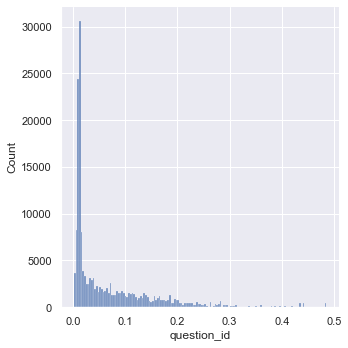

In [138]:
sns.displot(train2pl.question_id.map(ddisc))

In [139]:
valid2plmul.isna().sum()

user_id                                   0
session_id                                0
session_no                                0
topic                                     0
sub_topic                                 0
learning_node                             0
question_id                               0
question_type                             0
session_question_no                       0
learning_node_question_no                 0
question_difficulty                       0
question_number_of_choice                 0
question_number_of_correct_choice         0
question_number_of_correct_selected       0
question_number_of_wrong_selected         0
ms_first_response                         0
is_correct                                0
row_id                                    0
abilitydisc                             210
diffdisc                               2987
dtype: int64

In [140]:
clft2plmul = CatBoostClassifier(**CATBOOST_PARAM)
clft2plmul.fit(
    X_train2plmul,
    y_train2plmul,
    cat_features,
    eval_set=(X_valid2plmul, y_valid2plmul),
    **CATBOOST_FIT_PARAM
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [144]:
pd.DataFrame([clft2plmul.feature_names_,clft2plmul.get_feature_importance()]).T 

,0,1
0,question_number_of_choice,3.58158
1,question_id,16.511198
2,topic,12.047959
3,question_difficulty,1.654876
4,question_type,0.0
5,learning_node,13.890644
6,sub_topic,2.164407
7,abilitydisc,42.890872
8,diffdisc,7.258464


### IRT-4PL-not-multiplied on split

In [51]:
!py-irt train 4pl trainsplit.jsonl train4pl


[19:45:03] config: model_type='4pl' epochs=2000 priors=None           cli.py:66
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                    
           dropout=0.5 hidden=100 vocab_size=None                              
           data_path: trainsplit.jsonl                                cli.py:68
           output directory: train4pl                                 cli.py:69
False
None
[19:45:04] Training Model...                                          cli.py:73
{'device': 'cpu', 'num_items': 26206, 'num_subjects': 6723}
[19:45:04] Parsed Model Args: {'device': 'cpu', 'num_items':    training.py:124
           26206, 'num_subjects': 6723, 'priors': 'vague',                     
           'dropout': 0.5, 'hidden': 100, 'vocab_size': None}                  
torch.Size([120884]) torch.Size([120884])
Training Pyro IRT Model for 2000 epochs
+----------------------------------------------+
| Epoch | Loss         | Best Loss    | New LR |
|-------+--------------+-----

In [209]:
# transform from irt input
import json

f = open("train4pl/best_parameters.json").read()
d = json.loads(f)
duid = {int(k): int(v) for k, v in d["subject_ids"].items()}
dability = dict(zip(map(int, d["subject_ids"].values()), d["ability"]))
ddiff = dict(zip(map(int, d["item_ids"].values()), d["diff"]))
ddisc = dict(zip(map(int, d["item_ids"].values()), d["disc"]))
dlambdas = dict(zip(map(int, d["item_ids"].values()), d["lambdas"]))

train4pl = train.copy()
valid4pl = valid.copy()
test4pl = test.copy()

# transform to irt
train4pl["ability"] = train4pl.user_id.map(dability)
train4pl["diff"] = train4pl.question_id.map(ddiff)
train4pl["disc"] = train4pl.question_id.map(ddisc)
train4pl["lambdas"] = train4pl.question_id.map(dlambdas)

valid4pl["ability"] = valid4pl.user_id.map(dability)
valid4pl["diff"] = valid4pl.question_id.map(ddiff)
valid4pl["disc"] = valid4pl.question_id.map(ddisc)
valid4pl["lambdas"] = valid4pl.question_id.map(dlambdas)

test4pl["ability"] = test4pl.user_id.map(dability)
test4pl["diff"] = test4pl.question_id.map(ddiff)
test4pl["disc"] = test4pl.question_id.map(ddisc)
test4pl["lambdas"] = test4pl.question_id.map(dlambdas)

lis_int4 = list_inter + ["ability", "diff", "disc", "lambdas"]

X_train4pl = train4pl[lis_int4].drop(drop_cols, axis=1)
y_train4pl = train4pl.is_correct

X_valid4pl = valid4pl[lis_int4].drop(drop_cols, axis=1)
y_valid4pl = valid4pl.is_correct

X_test4pl = test4pl[lis_int4].drop(drop_cols, axis=1)
y_test4pl = test4pl.is_correct

X_train4pl.columns,X_test4pl.columns


(Index(['question_number_of_choice', 'question_id', 'topic',
        'question_difficulty', 'question_type', 'learning_node', 'sub_topic',
        'ability', 'diff', 'disc', 'lambdas'],
       dtype='object'),
 Index(['question_number_of_choice', 'question_id', 'topic',
        'question_difficulty', 'question_type', 'learning_node', 'sub_topic',
        'ability', 'diff', 'disc', 'lambdas'],
       dtype='object'))

In [207]:
X_valid4pl.isna().sum()


question_number_of_choice       0
question_id                     0
topic                           0
question_difficulty             0
question_type                   0
learning_node                   0
sub_topic                       0
ability                       210
diff                         2987
disc                         2987
lambdas                      2987
dtype: int64

In [54]:
from catboost import CatBoostClassifier

clf4pl = CatBoostClassifier(**CATBOOST_PARAM)
clf4pl.fit(
    X_train4pl,
    y_train4pl,
    cat_features,
    eval_set=(
        X_valid4pl,
        y_valid4pl,
    ),
    **CATBOOST_FIT_PARAM
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [200]:
yp = clf4pl.predict_proba(X_train4pl)
tr = roc_auc_score(y_train4pl, yp[:, 1])

yp = clf4pl.predict_proba(X_valid4pl)
va1 = roc_auc_score(y_valid4pl, yp[:, 1])

yp = clf4pl.predict_proba(X_valid4pl.fillna(X_valid4pl.mean()))
va2 = roc_auc_score(y_valid4pl, yp[:, 1])

yp = clf4pl.predict_proba(X_valid4pl.fillna(X_valid4pl.median()))
va3 = roc_auc_score(y_valid4pl, yp[:, 1])
# yp2=clf.predict_proba(X_test)
# te=roc_auc_score(y_test,yp2[:,1])

tr, va1, va2, va3


C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/827199090.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clf4pl.predict_proba(X_valid4pl.fillna(X_valid4pl.mean()))
C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/827199090.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clf4pl.predict_proba(X_valid4pl.fillna(X_valid4pl.median()))


(0.8752696367623871,
 0.7335351675563863,
 0.7280296728272194,
 0.7118920346595509)

In [201]:
xx4 = X_valid4pl.copy()
xx4["diff"] = X_valid4pl["diff"].fillna(
    X_valid4pl.groupby("question_difficulty")["diff"].transform("median")
)
xx4["disc"] = X_valid4pl["disc"].fillna(
    X_valid4pl.groupby("question_difficulty")["disc"].transform("median")
)
xx4["ability"] = X_valid4pl["ability"].fillna(X_valid4pl["ability"].median())


yp = clf4pl.predict_proba(xx4)
roc_auc_score(y_valid4pl, yp[:, 1])


0.7345317393746482

In [211]:
X_test4pl.columns

Index(['question_number_of_choice', 'question_id', 'topic',
       'question_difficulty', 'question_type', 'learning_node', 'sub_topic',
       'ability', 'diff'],
      dtype='object')

#### Test

In [212]:
X_test4pl = test4pl[lis_int4].drop(drop_cols, axis=1)
y_test4pl = test4pl.is_correct

yp = clf4pl.predict_proba(X_train4pl)
tr = roc_auc_score(y_train4pl, yp[:, 1])


yp = clf4pl.predict_proba(X_test4pl)
te1 = roc_auc_score(y_test4pl, yp[:, 1])

yp = clf4pl.predict_proba(X_test4pl.fillna(X_test4pl.mean()))
te2 = roc_auc_score(y_test4pl, yp[:, 1])

yp = clf4pl.predict_proba(X_test4pl.fillna(X_test4pl.median()))
ypred4pl=yp
te3 = roc_auc_score(y_test4pl, yp[:, 1])
# yp2=clf.predict_proba(X_test)
# te=roc_auc_score(y_test,yp2[:,1])

tr, te1, te2, te3


C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/2174251803.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clf4pl.predict_proba(X_test4pl.fillna(X_test4pl.mean()))
C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/2174251803.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yp = clf4pl.predict_proba(X_test4pl.fillna(X_test4pl.median()))


(0.8752696367623871,
 0.7343600966700442,
 0.7267304185567625,
 0.7090623833593387)

In [220]:
# ## Perbandingan distribution plot 2-PL vs 4-PL
# sns.distplot(X_valid2pl["ability"])
# sns.distplot(X_valid2pl["diff"])
# sns.distplot(X_valid2pl["disc"])
# sns.distplot(X_valid4pl["ability"])
# sns.distplot(X_valid4pl["diff"])
# sns.distplot(X_valid4pl["disc"])
# sns.distplot(X_valid4pl["lambdas"])


# ROC Curve

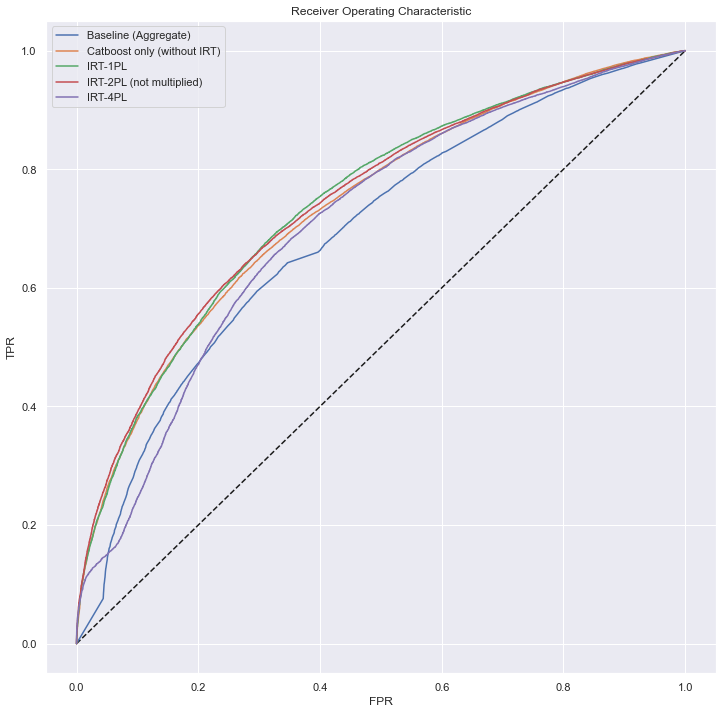

In [217]:
#ROC Curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fprb , tprb, thresholdsb = roc_curve(y_test1pl, ypbaseline)
fprcb , tprcb, thresholdscb = roc_curve(y_test1pl, ypredcbonly[:,1])
fpr1 , tpr1, thresholds1 = roc_curve(y_test1pl, ypred1pl[:,1])
fpr2 , tpr2, thresholds2 = roc_curve(y_test2pl, ypred2plnotmul[:,1])
fpr4 , tpr4, thresholds4 = roc_curve(y_test2pl, ypred4pl[:,1])


plt.plot([0,1],[0,1], 'k--')
plt.plot(fprb, tprb, label= "Baseline (Aggregate)")
plt.plot(fprcb, tprcb, label= "Catboost only (without IRT)")
plt.plot(fpr1, tpr1, label= "IRT-1PL")
plt.plot(fpr2, tpr2, label= "IRT-2PL (not multiplied)")
plt.plot(fpr4, tpr4, label= "IRT-4PL")

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

Pada ROC Curve dapat dilihat bahwa kemampuan model Catboost+IRT jauh lebih baik dari Catboost-only dan Baseline Aggregate.  
Sedangkan antar model IRT, walau AUC IRT-2PL sedikit lebih tinggi daripada 1PL dan 4PL, trade off-nya tidak begitu berbeda

# Modelling conclusion

Dari hasil eksperimen, ditemukan bahwa:
- model IRT sebagai fitur dapat meningkatkan AUC model CatBoost
- saat training model, kurva validation AUC yang konvergen hanya dimiliki oleh `CatBoost-only` dan `Catboost + 2PL-IRT-not-multiplied`
- AUC terbaik diraih oleh CatBoost dengan 2PL-IRT sebagai fitur, yaitu dengan tambahan fitur `student_ability`, `question_difficulty`, dan `question_discrimination`
- rumus IRT-2PL adalah `discrimination(ability - difficulty)`, namun model CatBoost bekerja lebih baik saat `student_ability`, `question_difficulty`, dan `question_discrimination` menjadi fitur terpisah (`model IRT-2PL-not-multiplied`) dibandingkan dikali (`model IRT-2PL-multiplied`)
- perkalian antara `ability` dan `discrimination`, membuat lebih banyak missing values karena banyak `discrimination` yang missing. dari hasil eksperimen terlihat imputation pada `discrimination` sebelum dikali, tidak membuat model `model IRT-2PL-not-multiplied` lebih bagus daripada dipisah `model IRT-2PL-not-multiplied`

Atas temuan-temuan di atas, terutama dari  smoothness validation AUC curve dan nilai test AUC, Catboost + IRT-2PL-not-multiplied digunakan sebagai model untuk final submission

## Tuning iterations

Karena  Catboost + IRT-2PL-not-multiplied mampu converge dengan cukup smooth dibandingkan model-model lainnya, maka dilakukan sekali lagi eksperimen untuk mencari jumlah max `iterations` terbaik

In [146]:
# transform from irt input
import json

f = open("train2pl/best_parameters.json").read()
d = json.loads(f)
duid = {int(k): int(v) for k, v in d["subject_ids"].items()}
dability = dict(zip(map(int, d["subject_ids"].values()), d["ability"]))
ddiff = dict(zip(map(int, d["item_ids"].values()), d["diff"]))
ddisc = dict(zip(map(int, d["item_ids"].values()), d["disc"]))

train2pl = train.copy()
valid2pl = valid.copy()
test2pl = test.copy()

# transform to irt
train2pl["ability"] = train2pl.user_id.map(dability)
train2pl["diff"] = train2pl.question_id.map(ddiff)
train2pl["disc"] = train2pl.question_id.map(ddisc)
# train3['lambdas'] =train3.question_id.map(dlambdas)

valid2pl["ability"] = valid2pl.user_id.map(dability)
valid2pl["diff"] = valid2pl.question_id.map(ddiff)
valid2pl["disc"] = valid2pl.question_id.map(ddisc)
# valid3['lambdas'] =valid3.question_id.map(dlambdas)

test2pl["ability"] = test2pl.user_id.map(dability)
test2pl["diff"] = test2pl.question_id.map(ddiff)
test2pl["disc"] = test2pl.question_id.map(ddisc)

lis_int2 = list_inter + ["ability", "diff", "disc"]

X_train2pl = train2pl[lis_int2].drop(drop_cols, axis=1)
y_train2pl = train2pl.is_correct

X_valid2pl = valid2pl[lis_int2].drop(drop_cols, axis=1)
y_valid2pl = valid2pl.is_correct

X_train2pl.columns


Index(['question_number_of_choice', 'question_id', 'topic',
       'question_difficulty', 'question_type', 'learning_node', 'sub_topic',
       'ability', 'diff', 'disc'],
      dtype='object')

In [147]:
from catboost import CatBoostClassifier

clf2pltrainiter = CatBoostClassifier(**{**CATBOOST_PARAM, "iterations": 2000})
clf2pltrainiter.fit(
    X_train2pl,
    y_train2pl,
    cat_features,
    eval_set=(X_valid2pl, y_valid2pl),
    **CATBOOST_FIT_PARAM
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Final submission

In [223]:
dfinal = df.copy()
transform_to_irt_input(dfinal, "final.jsonl")


In [224]:
!py-irt train 2pl final.jsonl final2pl


[23:23:45] config: model_type='2pl' epochs=2000 priors=None           cli.py:66
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                    
           dropout=0.5 hidden=100 vocab_size=None                              
           data_path: final.jsonl                                     cli.py:68
           output directory: final2pl                                 cli.py:69
False
None
[23:23:46] Training Model...                                          cli.py:73
{'device': 'cpu', 'num_items': 30653, 'num_subjects': 7000}
[23:23:46] Parsed Model Args: {'device': 'cpu', 'num_items':    training.py:124
           30653, 'num_subjects': 7000, 'priors': 'vague',                     
           'dropout': 0.5, 'hidden': 100, 'vocab_size': None}                  
torch.Size([172995]) torch.Size([172995])
Training Pyro IRT Model for 2000 epochs
+--------------------------------------------------+
| Epoch | Loss           | Best Loss      | New LR |
|-------+------------

In [225]:
# transform from irt input
import json

f = open("final2pl/best_parameters.json").read()
d = json.loads(f)
duid = {int(k): int(v) for k, v in d["subject_ids"].items()}
dability = dict(zip(map(int, d["subject_ids"].values()), d["ability"]))
ddiff = dict(zip(map(int, d["item_ids"].values()), d["diff"]))
ddisc = dict(zip(map(int, d["item_ids"].values()), d["disc"]))
# dlambdas = dict(zip(map(int,map(remove_q,d['item_ids'].values())), d['lambdas']))


In [226]:
dfinal2pl = dfinal.copy()

# transform to irt
dfinal2pl["ability"] = dfinal.user_id.map(dability)
dfinal2pl["diff"] = dfinal.question_id.map(ddiff)
dfinal2pl["disc"] = dfinal.question_id.map(ddisc)


In [227]:
dfinal2pl.isna().any()


user_id                                False
session_id                             False
session_no                             False
topic                                  False
sub_topic                              False
learning_node                          False
question_id                            False
question_type                          False
session_question_no                    False
learning_node_question_no              False
question_difficulty                    False
question_number_of_choice              False
question_number_of_correct_choice      False
question_number_of_correct_selected    False
question_number_of_wrong_selected      False
ms_first_response                      False
is_correct                             False
row_id                                 False
ability                                False
diff                                   False
disc                                   False
dtype: bool

In [228]:
lis_int2 = list_inter + ["ability", "diff", "disc"]


In [229]:
Xfinal2pl = dfinal2pl[lis_int2].drop(drop_cols, axis=1)
yfinal2pl = dfinal2pl.is_correct


In [230]:
Xfinal2pl.columns


Index(['question_number_of_choice', 'question_id', 'topic',
       'question_difficulty', 'question_type', 'learning_node', 'sub_topic',
       'ability', 'diff', 'disc'],
      dtype='object')

In [239]:
from catboost import CatBoostClassifier

clfinal = CatBoostClassifier(**{**CATBOOST_PARAM,"iterations": 433})
clfinal.fit(Xfinal2pl, yfinal2pl, cat_features, **CATBOOST_FIT_PARAM)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


In [240]:
yp = clfinal.predict_proba(Xfinal2pl)
tr = roc_auc_score(yfinal2pl, yp[:, 1])


tr


0.8469196178871268

In [241]:
testdf2pl = testdf.copy()
testdf2pl["ability"] = testdf.user_id.map(dability)
testdf2pl["diff"] = testdf.question_id.map(ddiff)
testdf2pl["disc"] = testdf.question_id.map(ddisc)
testdf2pl = testdf2pl.fillna(testdf2pl.median())


C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/3928223850.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  testdf2pl = testdf2pl.fillna(testdf2pl.median())


In [242]:
Xtest2pl = testdf2pl[lis_int2].drop(drop_cols, axis=1)


In [243]:
Xtest2pl.head()


,question_number_of_choice,question_id,topic,question_difficulty,question_type,learning_node,sub_topic,ability,diff,disc
0,4,2226271822,1064573894,medium,Single choice,1683819444,6164056362,-0.159845,-0.029829,0.200297
1,4,8350981375,1737274108,medium,Single choice,8772005155,6197171301,0.154840,0.002770,0.033442
2,4,7911407965,2624511878,other,Single choice,1064446677,5665086549,-0.486006,-0.007871,0.041295
3,4,2368078655,147927464,other,Single choice,7469873307,5665086549,-0.084017,-0.001599,0.009031
4,4,6616709393,253258722,medium,Single choice,3261917054,2774427363,0.318915,0.042763,0.013122


In [244]:
ytfinal = clfinal.predict_proba(Xtest2pl)[:, 1]


In [245]:
dfsub = testdf2pl[["row_id"]]
dfsub["is_correct"] = ytfinal


C:\Users\mrlut\AppData\Local\Temp/ipykernel_7796/2499768619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsub["is_correct"] = ytfinal


In [246]:
dfsub.to_csv("submission.csv", index=None)
